# Class attention applied to a text classification task using FCN

## FROZEN, DO NOT MODIFY



This time we use a real dataset.

In [1]:
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer
import datasets

import wandb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import class_attention as cat

%load_ext autoreload
%autoreload 2


def detorch(x):
    return x.detach().cpu().numpy()

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


# Data

In [4]:
text_dataset = datasets.load_dataset("Fraser/news-category-dataset")
all_classes = text_dataset['train'].features['category_num'].names
print(all_classes)

Using custom data configuration default
Reusing dataset news_category (/home/vlialin/.cache/huggingface/datasets/news_category/default/0.0.0/737b7b6dff469cbba49a6202c9e94f9d39da1fed94e13170cf7ac4b61a75fb9c)


['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS', 'THE WORLDPOST', 'WEDDINGS', 'WOMEN', 'IMPACT', 'DIVORCE', 'CRIME', 'MEDIA', 'WEIRD NEWS', 'GREEN', 'WORLDPOST', 'RELIGION', 'STYLE', 'SCIENCE', 'WORLD NEWS', 'TASTE', 'TECH', 'MONEY', 'ARTS', 'FIFTY', 'GOOD NEWS', 'ARTS & CULTURE', 'ENVIRONMENT', 'COLLEGE', 'LATINO VOICES', 'CULTURE & ARTS', 'EDUCATION']


In [5]:
def sample_dataset(dataset, p):
    """
    Args:
        dataset: datasets.arrow_dataset.Dataset object
        p: float, 0 < p <= 1
    
    Returns:
        datasets.arrow_dataset.Dataset of size len(dataset) * p with random examples from the dataset
        sampled without replacement
    """
    if not 0 < p <= 1:
        raise ValueError(p)

    dataset_len = len(dataset)
    sample_size = int(p * dataset_len)

    ids = random.sample(range(len(dataset)), sample_size)
    
    # indexing actually creates dict with elements of len(ids), not a list
    sampled_dataset_dict = dataset[ids]
    sampled_dataset = datasets.arrow_dataset.Dataset.from_dict(sampled_dataset_dict)
    return sampled_dataset

In [6]:
toy_dataset = sample_dataset(text_dataset['train'], 0.01)
len(toy_dataset)

1606

In [7]:
toy_dataset[0]['headline']

'A Workplace-Safe Version Of Facebook Is Coming Soon'

# Text tokenizer

We use a bert tokenizer here, just because we can.

In [8]:
MODEL = 'distilbert-base-uncased'

text_tokenizer = AutoTokenizer.from_pretrained(MODEL, fast=True)
text_tokenizer.encode_plus(toy_dataset[0]['headline'])

{'input_ids': [101,
  1037,
  16165,
  1011,
  3647,
  2544,
  1997,
  9130,
  2003,
  2746,
  2574,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Label tokenizer

Just use a tokenizer without UNK, no need for special kind of numericalizer/encoder.

Note that the dataset we use (`Fraser/news-category-dataset`) has some interesting particularities in the class names.

For example, it has classes `STYLE` and `STYLE & BEAUTY` or `WORLD NEWS` and `NEWS`. I.e., some classes contain other classes names in their name.
The classes that have `&` in their name have a similar particularity. Some of the categories does not seem to be distinguishable. E.g., `THE WORLDPOST` and `WORLDPOST` or `ARTS & CULTURE` and `CULTURE & ARTS`.

In [9]:
from collections import defaultdict
from pprint import pprint

_all_classes = set(toy_dataset['category'])
_word2classes = defaultdict(set)

for _class_name in set(_all_classes):
    _similar_classes = []
    for _class_word in _class_name.split(' '):
        for _other_class in _all_classes:
            if _class_name != _other_class and _class_word in _other_class:
                _word2classes[_class_word].add(_other_class)

for _w, _c in _word2classes.items():
    print(f"{_w}\t: {', '.join(_c)}")

NEWS	: GOOD NEWS, WORLD NEWS, WEIRD NEWS
WORLDPOST	: WORLDPOST, THE WORLDPOST
ARTS	: CULTURE & ARTS, ARTS, ARTS & CULTURE
&	: STYLE & BEAUTY, CULTURE & ARTS, ARTS & CULTURE, FOOD & DRINK, HOME & LIVING
CULTURE	: CULTURE & ARTS, ARTS & CULTURE
LIVING	: HEALTHY LIVING, HOME & LIVING
WORLD	: WORLDPOST, THE WORLDPOST
STYLE	: STYLE, STYLE & BEAUTY
VOICES	: LATINO VOICES, BLACK VOICES, QUEER VOICES


In [10]:
label_tokenizer = cat.utils.make_whitespace_tokenizer(toy_dataset['category'], unk_token=None)
label_tokenizer.encode(toy_dataset[0]['category']).ids

[33]

# Dataset object

In [11]:
train_texts = toy_dataset['headline']
train_labels = toy_dataset['category']
dataset = cat.CatDataset(train_texts, text_tokenizer, train_labels, label_tokenizer)

dataset[0]

(tensor([  101,  1037, 16165,  1011,  3647,  2544,  1997,  9130,  2003,  2746,
          2574,   102]),
 tensor([33]))

# Collator

Collator also makes targets. Targets != labels as the labels are strings.

In [12]:
from pprint import pprint

collator = cat.CatCollator(pad_token_id=0)
text_batch, unique_labels, targets = collator([dataset[0], dataset[2]])

print('Text:')
pprint(text_batch)

print('\nUnique labels:')
pprint(unique_labels)

print('Targets:')
pprint(targets)

Text:
tensor([[  101,  1037, 16165,  1011,  3647,  2544,  1997,  9130,  2003,  2746,
          2574,   102],
        [  101,  3317,  2669,  2118,  2052,  2066,  2049, 13314,  9427,  2067,
           102,     0]])

Unique labels:
tensor([[33],
        [42]])
Targets:
tensor([0, 1])


# Dataloader

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=collator, shuffle=True)

In [14]:
next(iter(dataloader))

(tensor([[  101,  5264,  1005,  1055,  2034,  2931,  2343,  2097,  2022,  1037,
           7632,  3900,  2497,  1011,  4147,  5152,  2450,   102,     0,     0,
              0,     0,     0],
         [  101,  3021,  5003,  5886, 14021,  5596,  2015, 10643,  2005,  1005,
           5599,  8398,  2448,  2091,  2637,  1005,   102,     0,     0,     0,
              0,     0,     0],
         [  101,  3374,  1010,  2021,  8348,  1998,  1005,  2732,  5233,  1005,
           3152,  2024,  2975, 20907,   102,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  2340,  9577,  2135,  3376,  4230,  1997,  2300,  1006,  7760,
           1007,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  1996,  2187,  1010,  1996,  2157,  1998,  1996,  4372,  5666,
          20464,  7476,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  2025,  2673,  2003,  6

# Model

In [25]:
class FcClassAttentionModel(nn.Module):
    def __init__(self, text_vocab_size, n_classes, hidden_size):
        super().__init__()

        self.x_enc = nn.Sequential(nn.EmbeddingBag(text_vocab_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Sequential(nn.EmbeddingBag(n_classes, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

    def forward(self, text_input, labels_input):
        h_x = self.x_enc(text_input)
        h_c = self.c_enc(labels_input)

        logits = h_x @ h_c.T # + bias  # or make a residual connection with class network

        return logits

In [26]:
# Create the tokenizers right here?

model = FcClassAttentionModel(text_tokenizer.vocab_size, label_tokenizer.get_vocab_size(), hidden_size=64)

In [27]:
x = torch.randint(0, 100, size=[3, 5])
c = torch.unique(torch.randint(0, 100, size=[7, 1])).unsqueeze(1)

out = model(text_input=x, labels_input=c)
out.shape

torch.Size([3, 7])

## Train class attention

Possible reasons why the model does not converge are optimizational. E.g., explosive gradients, bad learning rate.
We can try to fix them via tuning a model on a very small dataset. Possibly, we also need to add some kind of normalization (PowerNorm?).

In [28]:
device = 'cuda'
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

Text(0.5, 1.0, 'Accuracy')

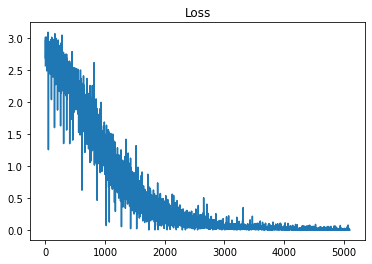

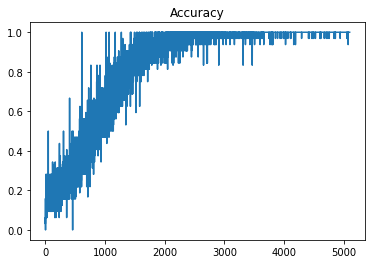

In [29]:
loss_hist = []
acc_hist = []

for _ in tqdm(range(100)):
    for x, c, y in dataloader:
        optimizer.zero_grad()

        x = x.to(device)
        c = c.to(device)
        y = y.to(device)

        x_dict = {'input_ids': x}
        c_dict = {'input_ids': c}
        logits = model(x, c)

        loss = F.cross_entropy(logits, y)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == y).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')